Part 0: Characterize task. What is difficult/interesting about it? Only PostMean. Bias and variance as a function of Delta s and gains.

Setup:

In [16]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.patches as mpatches
from functools import partial
import pickle

nneuron = 61
min_angle = -90
max_angle = 90
sprefs = np.linspace(min_angle, max_angle, nneuron)
eps = np.finfo(np.float64).eps
sigtc_sq = float(10**2)

In [4]:
def cartesian(arrays, out=None):
    """Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """
    arrays = [np.asarray(x) for x in arrays]
    shape = (len(x) for x in arrays)
    dtype = arrays[0].dtype

    ix = np.indices(shape)
    ix = ix.reshape(len(arrays), -1).T

    if out is None:
        out = np.empty_like(ix, dtype=dtype)

    for n, arr in enumerate(arrays):
        out[:, n] = arrays[n][ix[:, n]]

    return out

Generate data:

In [64]:
def random_s(ndata, sort):
    s = np.random.rand(2, ndata) * 120 - 60
    if sort:
        s = np.sort(s, axis=0)
    return s[0], s[1]

def random_c(ndata, ndims, low, high, sort):
    c_range = high - low
    if ndims == 1:
        c = np.random.rand(ndims, ndata)[0] * c_range + low
    else:
        c = np.random.rand(ndims, ndata) * c_range + low
    if sort:
        c = np.sort(c, axis=0)
    return c
    
def generate_popcode_data(ndata, nneuron, sigtc_sq, r_max, noise, sort, s_0, s_1, c_0, c_1, c_50=13.1):
    c_rms = np.sqrt(np.square(c_0) + np.square(c_1))
    sprefs_data = np.tile(sprefs, (ndata, 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_0, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c_0 * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c_1 * s_1t.T
    #r = r_max * (stim_0 + stim_1)/(c_50 + c_rms)
    r = r_max * (stim_0 + stim_1)
    r = r.T
    s = np.array((s_0, s_1)).T
    s = s/90
    c = np.array((c_0, c_1)).T
    if noise == "poisson":
        r = np.random.poisson(r) + 0.0
    return r, s, c

def generate_trainset(ndata, highlow=False, discrete_c=None, low=.3, high=.7, r_max=10):
    s_0, s_1 = random_s(ndata, True)
    if highlow:
        c_arr = np.concatenate((np.ones((ndata/2, 2)) * low, np.ones((ndata/2, 2)) * high), axis=0)
        np.random.shuffle(c_arr)
        c_0, c_1 = c_arr.T
    elif discrete_c:
        if type(discrete_c) == int:
            cs = np.linspace(low, high, discrete_c)
            perm_cs = cartesian((cs, cs))
        else:
            perm_cs = cartesian(discrete_c)
        c_arr = np.repeat(perm_cs, ndata/(discrete_c**2), axis=0)
        np.random.shuffle(c_arr)
        c_0, c_1 = c_arr.T
        print ndata/(discrete_c**2), "trials per contrast level"
        if ndata%(discrete_c**2) != 0:
            print "Not divisible, only generated", ndata / (discrete_c**2) * (discrete_c**2), "trials"
        ndata = ndata / (discrete_c**2) * (discrete_c**2)
    else:
        c_0, c_1 = np.ones((2, ndata)) * .5
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c

def generate_testset(ndata, stim_0=None, stim_1=None, con_0=None, con_1=None, discrete_c=None, low=.5, high=.5, r_max=10):
    if con_0:
        c_0 = np.ones(ndata) * con_0
        c_1 = np.ones(ndata) * con_1
    else:
        c_range = high - low
        if discrete_c:
            if type(discrete_c) == int:
                cs = np.linspace(low, high, discrete_c)
                perm_cs = cartesian((cs, cs))
            else:
                perm_cs = cartesian(discrete_c)
            c_0, c_1 = np.repeat(perm_cs, ndata/(discrete_c**2), axis=0).T
            print ndata/(discrete_c**2), "trials per contrast level"
            if ndata%(discrete_c**2) != 0:
                print "Not divisible, only generated", ndata / (discrete_c**2) * (discrete_c**2), "trials"
            ndata = ndata / (discrete_c**2) * (discrete_c**2)
        else:
            c_0, c_1 = np.random.rand(2, ndata) * c_range + low
    if not stim_0:
        s_0, s_1 = random_s(ndata, True)
    else:
        s_0, s_1 = np.ones((2, ndata))
        s_0 = s_0 * stim_0
        s_1 = s_1 * stim_1
    r, s, c = generate_popcode_data(ndata, nneuron, sigtc_sq, r_max, "poisson", True, s_0, s_1, c_0, c_1)
    return r, s, c

def generate_trainset_cat(ndata, low=.3, high=1.3, crange=.5, r_max=10):
    numvec = np.random.binomial(1, .5, size=ndata).astype(int)
    c_0 = random_c(ndata, 1, high, high+crange, True)
    c_1 = random_c(ndata, 1, low, low+crange, True)
    s_0, s_1 = np.random.rand(2, ndata) * 120 - 60
    r, numvec, s, c  = generate_popcode_data_cat(ndata, numvec, nneuron, sigtc_sq, c_50, r_max, "poisson", s_0, s_1, c_0, c_1)
    y = s[range(ndata), numvec]
    return r, y, s, c, numvec 
    
def generate_popcode_data_cat(ndata, numvec, nneuron, sigtc_sq, c_50, r_max, noise, s_0, s_1, c_0, c_1):
    c0vec = c_0 * np.ones(ndata)
    c1vec = c_1 * numvec
    c_rms = np.sqrt(np.square(c0vec) + np.square(c1vec))
    sprefs_data = np.tile(sprefs, (ndata, 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_0, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c0vec * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c1vec * s_1t.T
    #r = r_max * (stim_0 + stim_1)/(c_50 + c_rms)
    r = r_max * (stim_0 + stim_1)/(c_rms)
    #r = r_max * (stim_0 + stim_1)
    r = r.T
    s = np.array((s_0, s_1)).T
    s = s/90
    c = np.array((c_0, c_1)).T
    if noise == "poisson":
        r = np.random.poisson(r) + 0.0
    return r, numvec, s, c 

Posterior computation:

In [93]:
def lik_means(s_1, s_2, c_0=.5, c_1=.5, sprefs=sprefs, sigtc_sq=sigtc_sq, r_max=10):
    sprefs_data = np.tile(sprefs, (len(s_1), 1))
    s_0t = np.exp(-np.square((np.transpose(np.tile(s_1, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_0 = c_0 * s_0t.T
    s_1t = np.exp(-np.square((np.transpose(np.tile(s_2, (nneuron, 1))) - sprefs_data))/(2 * sigtc_sq))
    stim_1 = c_1 * s_1t.T
    r = r_max * (stim_0 + stim_1)
    return r.T
def posterior(r, means, s1_grid, s2_grid):
    ns_liks = poisson.pmf(r, mu=means)
    stim_liks = np.prod(ns_liks, axis=1)
    #p_s = 2/14400
    #logp_s = np.log(p_s)
    logp_s = -3.8573325
    #p_c = 1/9
    #logp_c = np.log(p_c)
    logp_c = -0.95424250943
    loglik = np.sum(np.log(ns_liks), axis=1)
    mean1 = np.sum(s1_grid * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    mean2 = np.sum(s2_grid * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    expsquare1 = np.sum(np.square(s1_grid) * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    expsquare2 = np.sum(np.square(s2_grid) * np.exp(loglik + logp_s + logp_c)/np.sum(np.exp(loglik + logp_s + logp_c)))
    var1 = expsquare1 - np.square(mean1)
    var2 = expsquare2 - np.square(mean2)
    return mean1, mean2, var1, var2
def posterior_setup(low=.3, high=.7, discrete_c = 3, num_s=100, r_max=10):
    grid = np.linspace(-60, 60, num_s)
    s1s = np.concatenate([[grid[i]]*(num_s-i) for i in range(num_s)])
    cs = np.linspace(low, high, discrete_c)
    s1_grid, c1_grid, c2_grid = cartesian((s1s, cs, cs)).T
    s2s = np.concatenate([grid[i:num_s+1] for i in range(num_s)])
    s2_grid = np.repeat(s2s, (discrete_c**2), axis=0)
    means = lik_means(s1_grid, s2_grid, c_0=c1_grid, c_1=c2_grid, r_max=r_max)
    partial_post = partial(posterior, means=means, s1_grid=s1_grid, s2_grid=s2_grid)
    return partial_post
def get_posteriors(r, post_func):
    posteriors = {'mean_s1': None, 'mean_s2': None, 'var_s1': None, 'var_s2': None}
    p = np.array([post_func(r[i]) for i in range(len(r))]).T
    posteriors['mean_s1'], posteriors['mean_s2'], posteriors['var_s1'], posteriors['var_s2'] = p
    return posteriors
def get_posteriors_pool(r, post_func):
    pool = mp.Pool(processes=8)
    posteriors = {'mean_s1': None, 'mean_s2': None, 'var_s1': None, 'var_s2': None}
    p = np.array(pool.map(post_func, r)).T
    posteriors['mean_s1'], posteriors['mean_s2'], posteriors['var_s1'], posteriors['var_s2'] = p
    return posteriors

Compute posterior statistics:

In [116]:
def get_statistics(s1, s2, preds):
    mean_s1 = np.mean(preds[0])
    mean_s2 = np.mean(preds[1])
    bias_s1 = mean_s1 - s1
    bias_s2 = mean_s2 - s2
    mse = np.mean((preds[0] - s1)**2 + (preds[1] - s2)**2)
    covmat = np.cov(preds)
    var_s1 = covmat[0, 0]
    var_s2 = covmat[1, 1]
    cov = covmat[0, 1]
    corr = cov / (np.sqrt(var_s1) * np.sqrt(var_s2))
    stats = {'mean_s1': mean_s1, 'mean_s2': mean_s2, 'bias_s1': bias_s1, 'bias_s2': bias_s2, 'var_s1': var_s1, 'var_s2': var_s2, 'cov': cov, 'corr': corr, 'mse': mse}
    return stats

In [74]:
s1 = -30
discrete_c = 3
ndata = 306
ndata_per_c = ndata/(discrete_c**2)
num_deltas = 60
r_max_arr = [1, 3, 5, 10, 30, 50, 100, 500, 1000]
all_stats = [None] * len(r_max_arr)
for i in xrange(len(r_max_arr)):
    print i
    post_func = posterior_setup(low=.3, high=.7, discrete_c=discrete_c, num_s=60, r_max=r_max_arr[i])
    post_stats = {'mean_s1': np.zeros((num_deltas, discrete_c**2)), 
                  'mean_s2': np.zeros((num_deltas, discrete_c**2)), 
                  'bias_s1': np.zeros((num_deltas, discrete_c**2)), 
                  'bias_s2': np.zeros((num_deltas, discrete_c**2)), 
                  'var_s1': np.zeros((num_deltas, discrete_c**2)), 
                  'var_s2': np.zeros((num_deltas, discrete_c**2)), 
                  'cov': np.zeros((num_deltas, discrete_c**2)), 
                  'corr': np.zeros((num_deltas, discrete_c**2)),
                  'posts': {}
                 }

    for delta_s in range(num_deltas):
        test_data = generate_testset(ndata, stim_0=s1, stim_1=s1+delta_s, discrete_c=discrete_c, low=.3, high=.7, r_max=r_max_arr[i])
        r, _, _ = test_data
        posts = get_posteriors(r, post_func)
        post_means = np.array((posts['mean_s1'], posts['mean_s2']))
        post_stats['posts'][delta_s] = posts
        for c in range(discrete_c**2):
            post_means_c = post_means.T[(ndata_per_c*c):(ndata_per_c*(c+1))]
            post_means_c = post_means_c.T
            stats = get_statistics(s1, s1 + delta_s, post_means_c)

            post_stats['mean_s1'][delta_s][c] = stats['mean_s1']
            post_stats['mean_s2'][delta_s][c] = stats['mean_s2']
            post_stats['bias_s1'][delta_s][c] = stats['bias_s1']
            post_stats['bias_s2'][delta_s][c] = stats['bias_s2']
            post_stats['var_s1'][delta_s][c] = stats['var_s1']
            post_stats['var_s2'][delta_s][c] = stats['var_s2']
            post_stats['cov'][delta_s][c] = stats['cov']
            post_stats['corr'][delta_s][c] = stats['corr']
    all_stats[i] = post_stats

0
34 trials per contrast level


In [ ]:
pkl_file = open('stats.pkl', 'wb')
pickle.dump(all_stats, pkl_file)
pkl_file.close()

In [17]:
pkl_file = open('stats.pkl', 'rb')
all_stats = pickle.load(pkl_file)

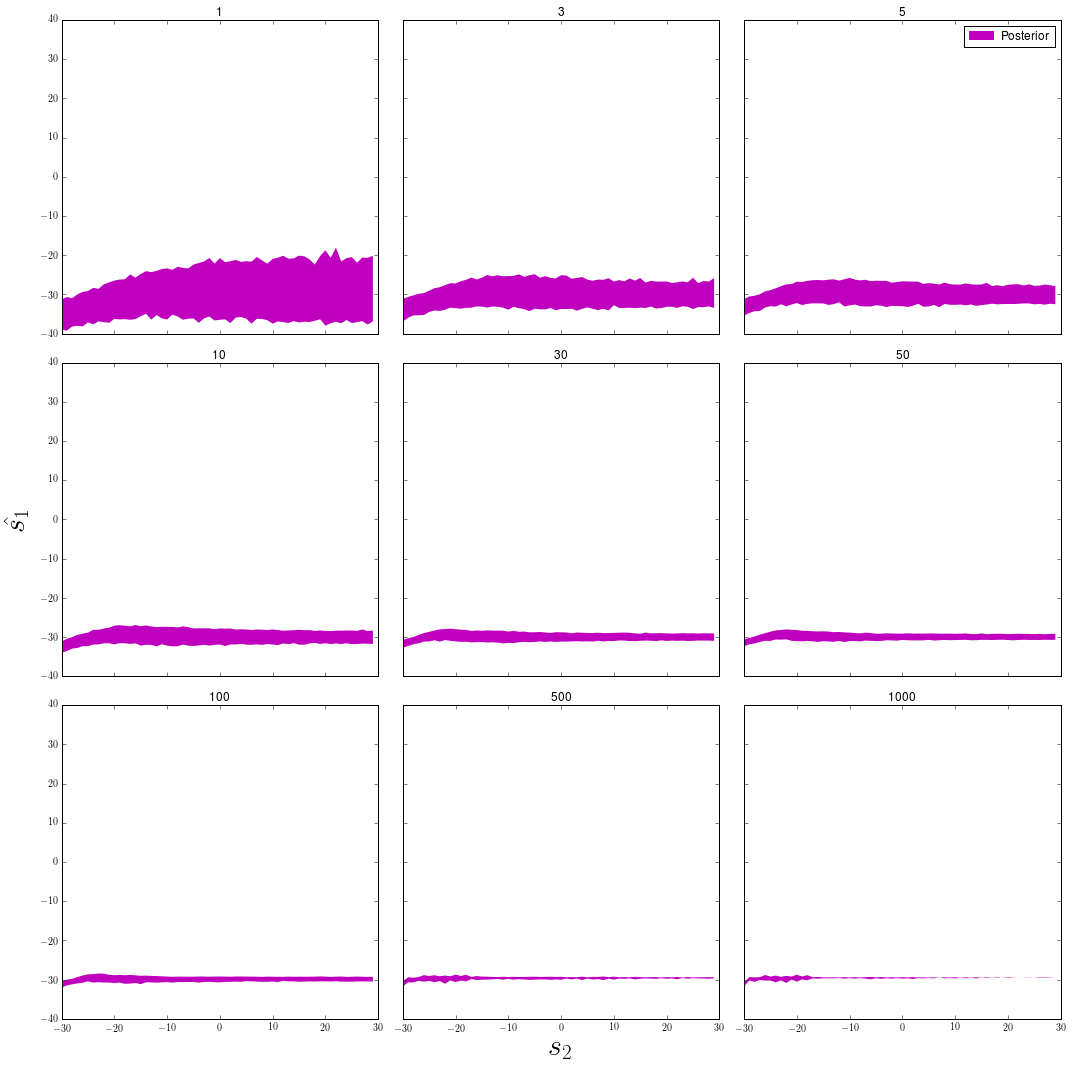

In [23]:
%matplotlib inline
s = range(-30, 30)
f, axarr = plt.subplots(3, 3, sharex=True, sharey=True)
plt.rc('text', usetex=True)
for i in range(3):
    for j in range(3):
        r = i * 3 + j
        neg_sd = np.mean(all_stats[r]['mean_s1'], axis=1) - np.mean(np.sqrt(all_stats[r]['var_s1']), axis=1)
        pos_sd = np.mean(all_stats[r]['mean_s1'], axis=1) + np.mean(np.sqrt(all_stats[r]['var_s1']), axis=1)
        axarr[i, j].fill_between(s, pos_sd, neg_sd, facecolor='m', edgecolor="None", label="Posterior")
        axarr[i, j].set_ylim([-40,40])
        axarr[i, j].set_title(r_max_arr[r])
axarr[2, 1].set_xlabel(r'$s_2$',fontsize=30)
axarr[1, 0].set_ylabel(r'\hat{s_1}',fontsize=30)
patch = mpatches.Patch(color='m', label='Posterior')
axarr[0, 2].legend(handles=[patch])
f.set_size_inches(15,15)
plt.tight_layout()
plt.show()

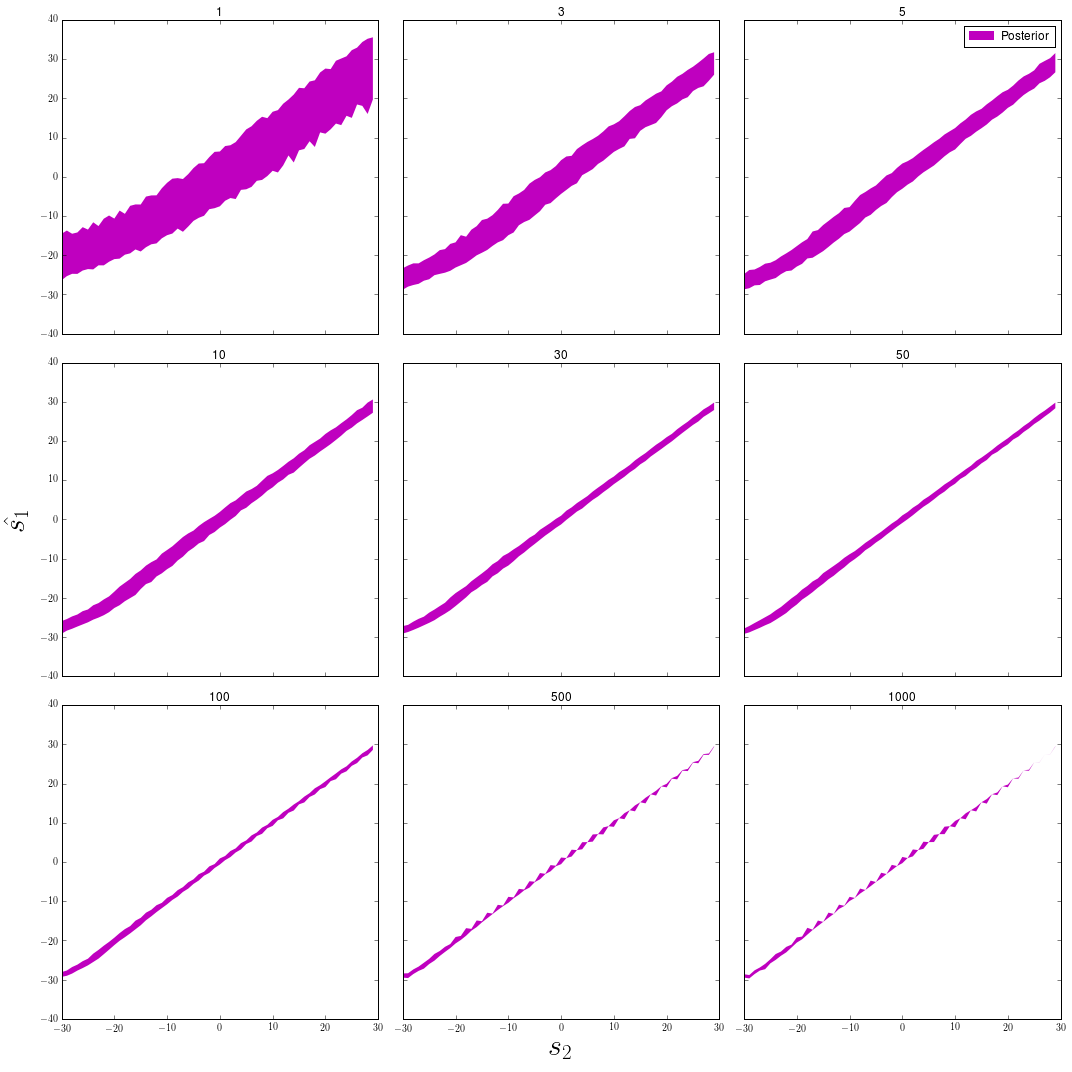

In [24]:
%matplotlib inline
f, axarr = plt.subplots(3, 3, sharex=True, sharey=True)
plt.rc('text', usetex=True)
for i in range(3):
    for j in range(3):
        r = i * 3 + j
        neg_sd = np.mean(all_stats[r]['mean_s2'], axis=1) - np.mean(np.sqrt(all_stats[r]['var_s2']), axis=1)
        pos_sd = np.mean(all_stats[r]['mean_s2'], axis=1) + np.mean(np.sqrt(all_stats[r]['var_s2']), axis=1)
        axarr[i, j].fill_between(s, pos_sd, neg_sd, facecolor='m', edgecolor="None", label="Posterior")
        axarr[i, j].set_ylim([-40,40])
        axarr[i, j].set_title(r_max_arr[r])
        """
        if r > 0:
            axarr[i, j].set_xticks([])
            axarr[i, j].set_yticks([])
        """
axarr[2, 1].set_xlabel(r'$s_2$',fontsize=30)
axarr[1, 0].set_ylabel(r'\hat{s_1}',fontsize=30)
patch = mpatches.Patch(color='m', label='Posterior')
axarr[0, 2].legend(handles=[patch])
f.set_size_inches(15,15)
plt.tight_layout()
plt.show()

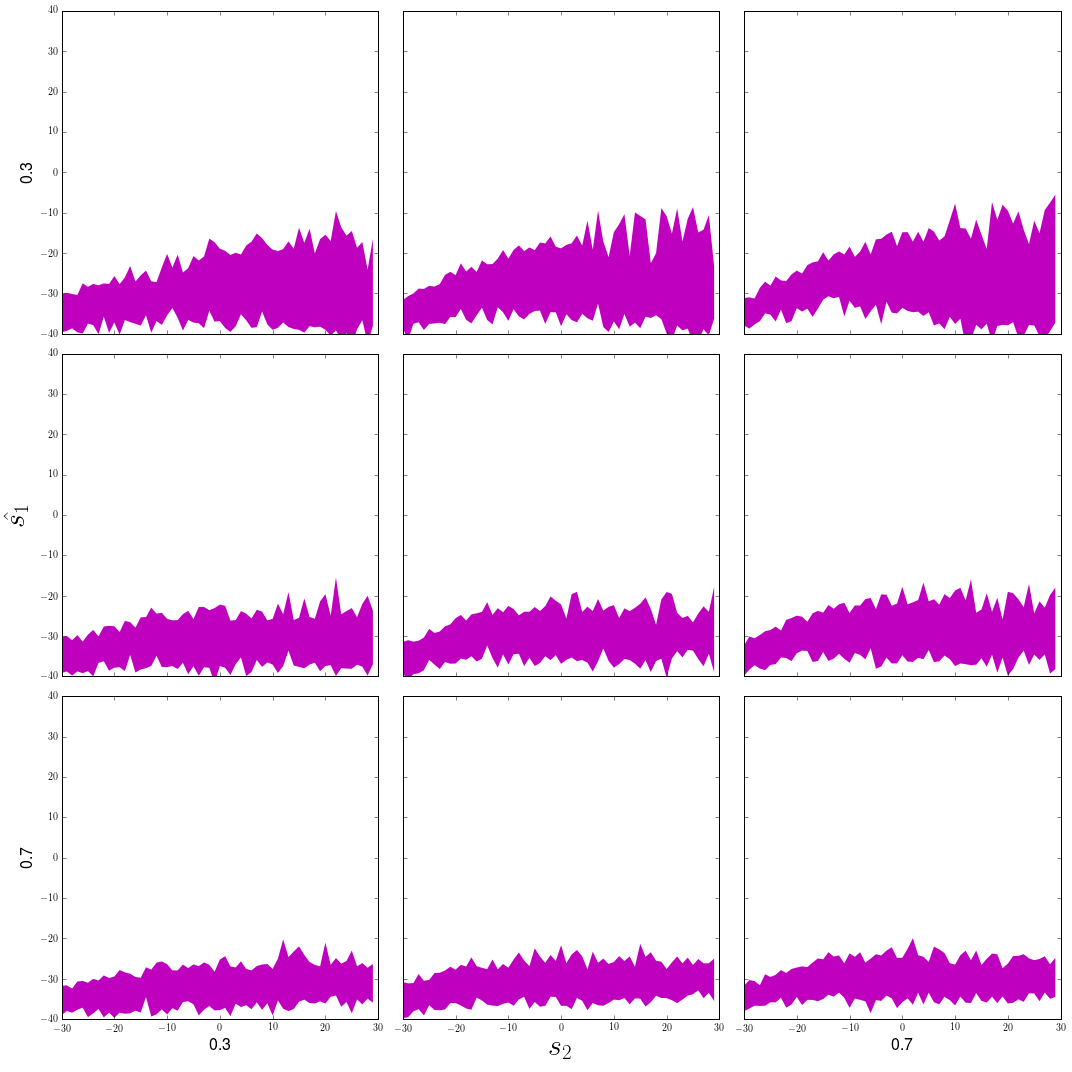

In [32]:
%matplotlib inline
r_max = 0
s = range(-30, 30)
f, ax = plt.subplots(3, 3, sharex=True, sharey=True)
plt.rc('text', usetex=True)
plt.ylim([-40,40])
neg_sd = all_stats[r_max]['mean_s1'] - np.sqrt(all_stats[r_max]['var_s1'])
pos_sd = all_stats[r_max]['mean_s1'] + np.sqrt(all_stats[r_max]['var_s1'])
for c in range(discrete_c**2):
    x, y = c/discrete_c, c%discrete_c
    ax[x, y].fill_between(s, pos_sd[:, c], neg_sd[:, c], facecolor='m', edgecolor="None", label="Posterior")
ax[2, 1].set_xlabel(r'$s_2$',fontsize=30)
ax[1, 0].set_ylabel(r'$\hat{s_1}$',fontsize=30)
ax[2, 0].set_xlabel(.3, fontsize=16)
ax[2, 2].set_xlabel(.7, fontsize=16)
ax[0, 0].set_ylabel(.3, fontsize=16)
ax[2, 0].set_ylabel(.7, fontsize=16)
f.set_size_inches(15,15)
plt.tight_layout()

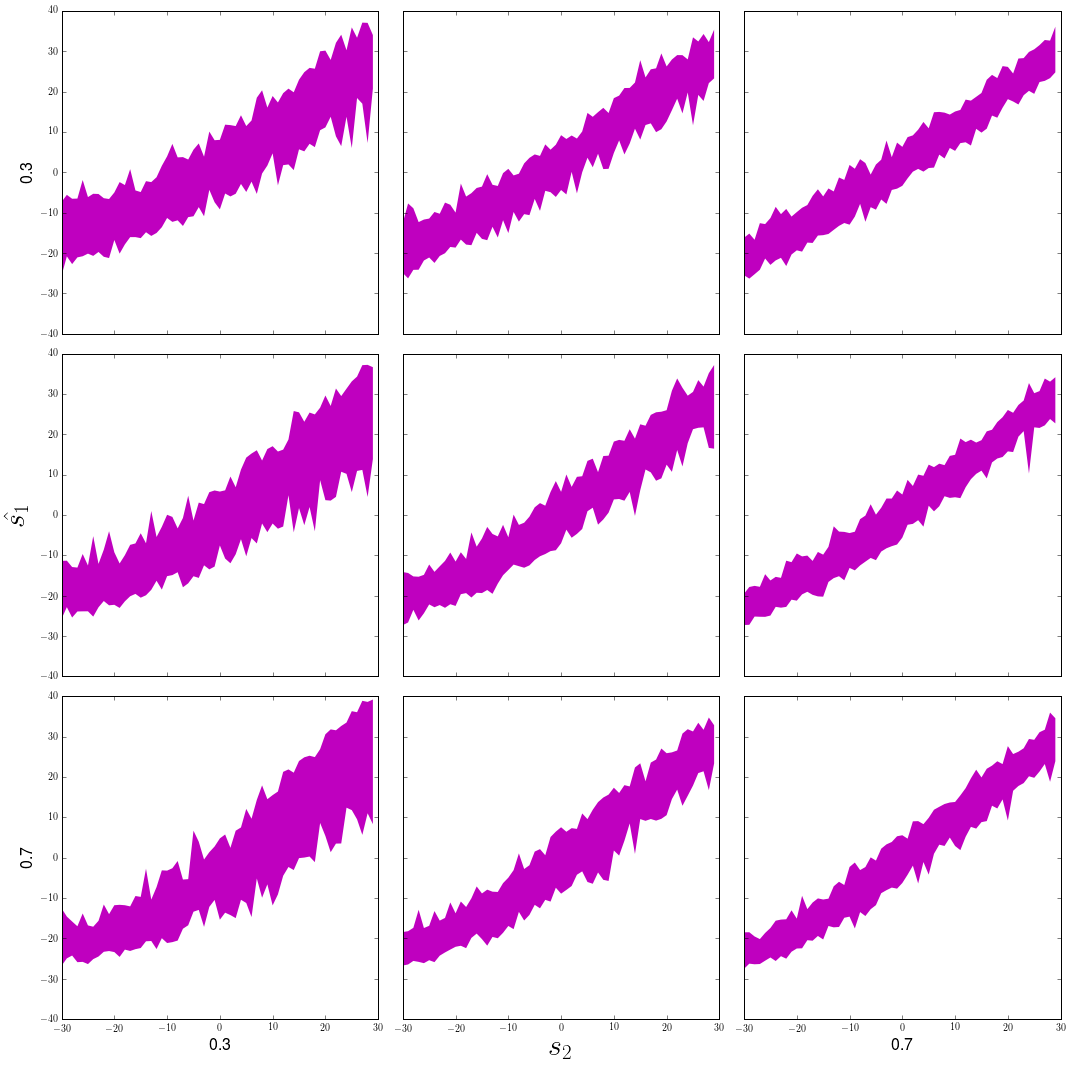

In [33]:
%matplotlib inline
r_max = 0
s = range(-30, 30)
f, ax = plt.subplots(3, 3, sharex=True, sharey=True)
plt.rc('text', usetex=True)
plt.ylim([-40,40])
neg_sd = all_stats[r_max]['mean_s2'] - np.sqrt(all_stats[r_max]['var_s2'])
pos_sd = all_stats[r_max]['mean_s2'] + np.sqrt(all_stats[r_max]['var_s2'])
for c in range(discrete_c**2):
    x, y = c/discrete_c, c%discrete_c
    ax[x, y].fill_between(s, pos_sd[:, c], neg_sd[:, c], facecolor='m', edgecolor="None", label="Posterior")
ax[2, 1].set_xlabel(r'$s_2$',fontsize=30)
ax[1, 0].set_ylabel(r'$\hat{s_1}$',fontsize=30)
ax[2, 0].set_xlabel(.3, fontsize=16)
ax[2, 2].set_xlabel(.7, fontsize=16)
ax[0, 0].set_ylabel(.3, fontsize=16)
ax[2, 0].set_ylabel(.7, fontsize=16)
f.set_size_inches(15,15)
plt.tight_layout()

In [120]:
import os
posts = {}
testsets = {}
for s_i in range(91):
    file_name = 'output_post/post_' + str(s_i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        p, r, c, delta_s = pickle.load(pkl_file)
        posts[c, delta_s] = p
        testsets[c, delta_s] = r

In [117]:
s1 = -30
ndata = 900
num_deltas = 30
c = 2
post_stats = {'mean_s1': np.zeros(num_deltas), 
                'mean_s2': np.zeros(num_deltas), 
                'bias_s1': np.zeros(num_deltas), 
                'bias_s2': np.zeros(num_deltas), 
                'var_s1': np.zeros(num_deltas), 
                'var_s2': np.zeros(num_deltas), 
                'cov': np.zeros(num_deltas), 
                'corr': np.zeros(num_deltas),
                'mse': np.zeros(num_deltas),
                }
for delta_s in range(num_deltas):
    post_means = np.array((posts[c, delta_s]['mean_s1'], posts[c, delta_s]['mean_s2']))
    stats = get_statistics(s1, s1 + delta_s, post_means)
    post_stats['mean_s1'][delta_s] = stats['mean_s1']
    post_stats['mean_s2'][delta_s] = stats['mean_s2']
    post_stats['bias_s1'][delta_s] = stats['bias_s1']
    post_stats['bias_s2'][delta_s] = stats['bias_s2']
    post_stats['var_s1'][delta_s] = stats['var_s1']
    post_stats['var_s2'][delta_s] = stats['var_s2']
    post_stats['cov'][delta_s] = stats['cov']
    post_stats['corr'][delta_s] = stats['corr']
    post_stats['mse'][delta_s] = stats['mse']

In [119]:
print np.mean(post_stats['mse'])

20.2534726967


In [121]:
pkl_file = open('posts.pkl', 'wb')
pickle.dump((posts, testsets), pkl_file)
pkl_file.close()